In [1]:
import pandas as pd
from pathlib import Path
import seaborn as sns
from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_csv("stroke/healthcare-dataset-stroke-data.csv", index_col="id")
df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
id,,,,,,,,,,,
9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [3]:
categorical_cols = ["gender", "hypertension", "heart_disease", "ever_married", "work_type", "Residence_type", "smoking_status"]
numerical_cols = ["age", "avg_glucose_level", "bmi"]


X = df[categorical_cols + numerical_cols]
y = df['stroke'].values.squeeze()
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=44)

In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score

In [5]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder

categorical_encoder = OrdinalEncoder(
    handle_unknown="use_encoded_value", unknown_value=-1, encoded_missing_value=-1
)
numerical_pipe = SimpleImputer(strategy="mean")

preprocessing = ColumnTransformer(
    [
        ("cat", categorical_encoder, categorical_cols),
        ("num", numerical_pipe, numerical_cols),
    ],
    verbose_feature_names_out=False,
)

rf = Pipeline(
    [
        ("preprocess", preprocessing),
        ("classifier", RandomForestClassifier(random_state=44)),
    ]
)
rf.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat',
                                                  OrdinalEncoder(encoded_missing_value=-1,
                                                                 handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['gender', 'hypertension',
                                                   'heart_disease',
                                                   'ever_married', 'work_type',
                                                   'Residence_type',
                                                   'smoking_status']),
                                                 ('num', SimpleImputer(),
                                                  ['age', 'avg_glucose_level',
                                                   'bmi'])],
                                   verbose_feature_names_out=False)),
                ('classifier', RandomForestClassifier(random_state=44))])

In [6]:
print(f"RF train accuracy: {rf.score(X_train, y_train):.3f}")
print(f"RF test accuracy: {rf.score(X_test, y_test):.3f}")

RF train accuracy: 1.000
RF test accuracy: 0.950


In [7]:
feature_names = rf[:-1].get_feature_names_out()

mdi_importances = pd.Series(
    rf[-1].feature_importances_, index=feature_names
).sort_values(ascending=True)

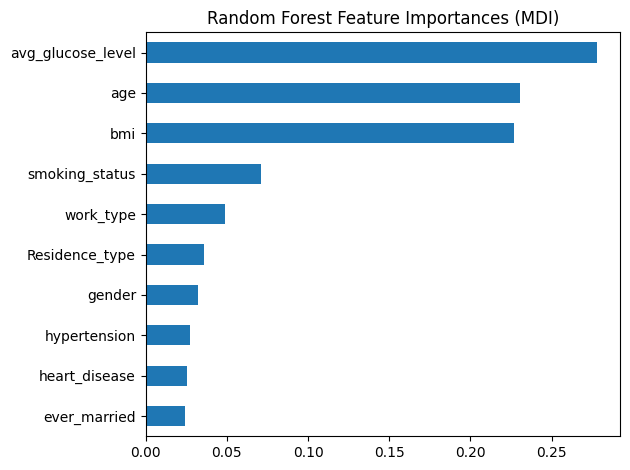

In [8]:
ax = mdi_importances.plot.barh()
ax.set_title("Random Forest Feature Importances (MDI)")
ax.figure.tight_layout()

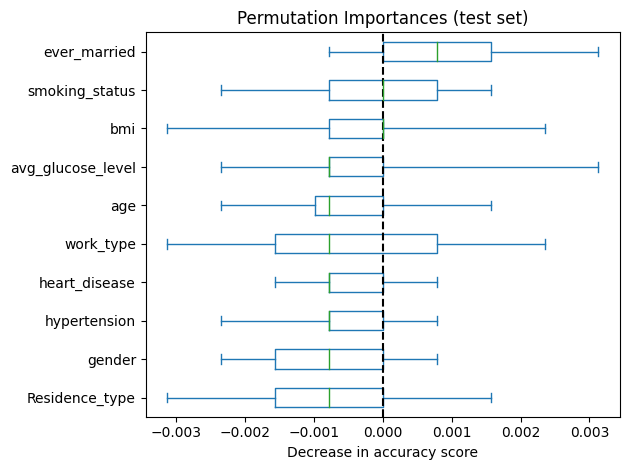

In [9]:
from sklearn.inspection import permutation_importance

result = permutation_importance(
    rf, X_test, y_test, n_repeats=100, random_state=42, n_jobs=12
)

sorted_importances_idx = result.importances_mean.argsort()
importances = pd.DataFrame(
    result.importances[sorted_importances_idx].T,
    columns=X.columns[sorted_importances_idx],
)
ax = importances.plot.box(vert=False, whis=10)
ax.set_title("Permutation Importances (test set)")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Decrease in accuracy score")
ax.figure.tight_layout()

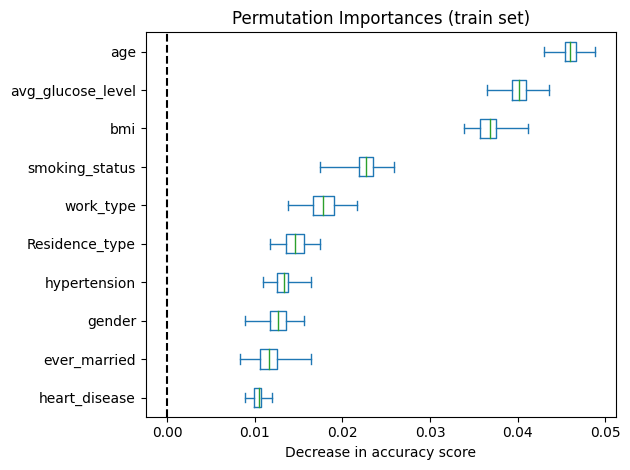

In [10]:
result = permutation_importance(
    rf, X_train, y_train, n_repeats=100, random_state=42, n_jobs=12
)

sorted_importances_idx = result.importances_mean.argsort()
importances = pd.DataFrame(
    result.importances[sorted_importances_idx].T,
    columns=X.columns[sorted_importances_idx],
)
ax = importances.plot.box(vert=False, whis=10)
ax.set_title("Permutation Importances (train set)")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Decrease in accuracy score")
ax.figure.tight_layout()

In [11]:
reg = Pipeline(
    [
        ("preprocess", preprocessing),
        ("classifier", LogisticRegression(max_iter=1000)),
    ]
)
reg.fit(X_train, y_train)

reg["classifier"].coef_

array([[ 0.03444424,  0.3814195 ,  0.5492565 , -0.49324469, -0.07736791,
         0.07668754, -0.08346122,  0.07499233,  0.00363131,  0.00694026]])

In [12]:
print(f"Logistic train accuracy: {reg.score(X_train, y_train):.3f}")
print(f"Logistic test accuracy: {reg.score(X_test, y_test):.3f}")

Logistic train accuracy: 0.951
Logistic test accuracy: 0.951


In [13]:
valid_pred = reg.predict(X_test)
mean_squared_error(y_test, valid_pred), r2_score(y_test, valid_pred)

(0.04929577464788732, -0.06793824278438043)

In [14]:
from autogluon.tabular import TabularDataset, TabularPredictor

all_data = TabularDataset('stroke/healthcare-dataset-stroke-data.csv').drop('id', axis=1)
train_data = all_data.sample(frac=0.8)
test_data = all_data.drop(train_data.index)
test_labels = test_data['stroke']
test_data = test_data.drop('stroke', axis=1)
train_data.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
3113,Female,62.0,1,0,Yes,Private,Urban,78.02,36.4,never smoked,0
2962,Female,70.0,1,0,Yes,Self-employed,Rural,154.60,28.5,formerly smoked,0
2886,Female,70.0,1,0,Yes,Self-employed,Rural,103.89,30.0,never smoked,0
1854,Female,68.0,0,0,Yes,Self-employed,Rural,93.61,24.9,never smoked,0
494,Female,55.0,0,0,Yes,Private,Rural,111.19,39.7,formerly smoked,0


In [41]:
save_path = 'stroke/agModels-predictClass-stroke'  # specifies folder to store trained models
predictor = TabularPredictor(label="stroke", eval_metric='precision', path=save_path).fit(train_data)

Beginning AutoGluon training ...
AutoGluon will save models to "stroke/agModels-predictClass-stroke/"
AutoGluon Version:  0.6.0
Python Version:     3.9.15
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #152-Ubuntu SMP Wed Nov 23 20:19:22 UTC 2022
Train Data Rows:    4088
Train Data Columns: 10
Label Column: stroke
Preprocessing data ...
AutoGluon infers your prediction problem is: 'binary' (because only two unique label-values observed).
	2 unique label values:  [0, 1]
	If 'binary' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Selected class <--> label mapping:  class 1 = 1, class 0 = 0
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    34918.21 MB
	Train Data (Original)  Memory Usage: 1.46 MB (0.0% of available memory)
	Inferring data type o

In [42]:
test_eval = predictor.evaluate_predictions(y_true=test_labels, y_pred=predictor.predict(test_data), auxiliary_metrics=True, silent=True)

In [43]:
predictor.leaderboard(all_data.drop(train_data.index), silent=True)

/home/cayler/envs/autogluon/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/cayler/envs/autogluon/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,model,score_test,score_val,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,LightGBMLarge,0.500000,1.000,0.050227,0.004307,1.082931,0.050227,0.004307,1.082931,1,True,13
1,XGBoost,0.400000,1.000,0.047336,0.005850,0.671137,0.047336,0.005850,0.671137,1,True,11
2,WeightedEnsemble_L2,0.400000,1.000,0.048523,0.007030,1.575241,0.001187,0.001180,0.904104,2,True,14
3,RandomForestGini,0.333333,0.800,0.081015,0.053281,0.451307,0.081015,0.053281,0.451307,1,True,5
4,NeuralNetFastAI,0.250000,1.000,0.021548,0.012616,2.823923,0.021548,0.012616,2.823923,1,True,10
5,RandomForestEntr,0.250000,0.800,0.068175,0.055659,0.464831,0.068175,0.055659,0.464831,1,True,6
6,KNeighborsUnif,0.100000,1.000,0.005951,0.007165,0.005634,0.005951,0.007165,0.005634,1,True,1
7,KNeighborsDist,0.058824,0.125,0.009715,0.007310,0.006368,0.009715,0.007310,0.006368,1,True,2
8,LightGBM,0.000000,1.000,0.002733,0.004280,0.585349,0.002733,0.004280,0.585349,1,True,4
9,CatBoost,0.000000,0.000,0.003931,0.003381,0.811163,0.003931,0.003381,0.811163,1,True,7


In [44]:
predictor.feature_importance(all_data.drop(train_data.index))

Computing feature importance via permutation shuffling for 10 features using 1022 rows with 5 shuffle sets...
	1.54s	= Expected runtime (0.31s per shuffle set)
	0.3s	= Actual runtime (Completed 5 of 5 shuffle sets)


,importance,stddev,p_value,n,p99_high,p99_low
bmi,3.600000e-01,0.089443,0.000422,5,0.544164,0.175836
age,3.000000e-01,0.223607,0.019971,5,0.760409,-0.160409
heart_disease,1.285714e-01,0.019562,0.000062,5,0.168849,0.088294
avg_glucose_level,1.156061e-01,0.116799,0.045649,5,0.356097,-0.124885
Residence_type,5.333333e-02,0.029814,0.008065,5,0.114721,-0.008055
ever_married,3.928571e-02,0.071874,0.144359,5,0.187274,-0.108703
gender,3.000000e-02,0.067082,0.186950,5,0.168123,-0.108123
hypertension,2.000000e-02,0.073030,0.286696,5,0.170369,-0.130369
smoking_status,3.330669e-17,0.091287,0.500000,5,0.187961,-0.187961
work_type,-2.000000e-02,0.044721,0.813050,5,0.072082,-0.112082


In [45]:
sum(y_train)/len(y_train)

0.04879958246346555

In [46]:
sum(y_test)/len(y_test)

0.048513302034428794

In [47]:
from sklearn.metrics import precision_score, recall_score, f1_score

In [48]:
precision_score(test_labels, predictor.predict(test_data)), recall_score(test_labels, predictor.predict(test_data)), f1_score(test_labels, predictor.predict(test_data))

(0.4, 0.04, 0.07272727272727272)

In [28]:
precision_score(y_test, reg.predict(X_test)), recall_score(y_test, reg.predict(X_test)), f1_score(y_test, reg.predict(X_test))

(0.0, 0.0, 0.0)

In [32]:
precision_score(y_test, rf.predict(X_test)), recall_score(y_test, rf.predict(X_test)), f1_score(y_test, rf.predict(X_test))

(0.25, 0.016129032258064516, 0.030303030303030304)